In [19]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


In [20]:
all_draft_data = pd.read_csv('../data/2025/all_draft_data.csv')
all_draft_data.head()

,pick_no,round,scoring_type,qb_need,rb_need,wr_need,te_need,k_need,dst_need,flex_need,...,dst_available,flex_available,qb_vor,rb_vor,wr_vor,te_vor,k_vor,flex_vor,position_drafted,draft_id
0,1,1,0.0,1,2,2,1,1,1,2,...,32,151,69.0,164.0,125.0,68.0,17.0,164.0,WR,1224007842931937280
1,2,1,0.0,1,2,2,1,1,1,2,...,32,150,69.0,164.0,116.0,68.0,17.0,164.0,WR,1224007842931937280
2,3,1,0.0,1,2,2,1,1,1,2,...,32,149,69.0,164.0,116.0,68.0,17.0,164.0,RB,1224007842931937280
3,4,1,0.0,1,2,2,1,1,1,2,...,32,148,69.0,154.0,116.0,68.0,17.0,154.0,RB,1224007842931937280
4,5,1,0.0,1,2,2,1,1,1,2,...,32,147,69.0,154.0,116.0,68.0,17.0,154.0,WR,1224007842931937280


In [21]:
draft_data = all_draft_data[~all_draft_data['round'].isin([14, 15])].copy()
draft_data.drop(columns=['k_need','k_available','k_vor','other_k_need','dst_available','dst_need','other_dst_need','flex_available','flex_need','flex_vor','other_flex_need',                'qb_available','rb_available','wr_available','te_available'], inplace=True)
numeric_cols = ['qb_need','rb_need','wr_need','te_need',
                'other_qb_need','other_rb_need','other_wr_need','other_te_need',
                'qb_vor','rb_vor','wr_vor','te_vor',
                'pick_no','round']
scaler = StandardScaler()
draft_data[numeric_cols] = draft_data[numeric_cols].astype(float)
draft_data.loc[:, numeric_cols] = scaler.fit_transform(draft_data[numeric_cols])

le = LabelEncoder()
draft_data['position_drafted_encoded'] = le.fit_transform(draft_data['position_drafted'])

In [22]:
train_val, test = train_test_split(draft_data, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)
X_train = train.drop(columns=['draft_id', 'position_drafted','position_drafted_encoded'])
y_train = train['position_drafted_encoded']
X_val = val.drop(columns=['draft_id', 'position_drafted','position_drafted_encoded'])
y_val = val['position_drafted_encoded']
X_test = test.drop(columns=['draft_id', 'position_drafted','position_drafted_encoded'])
y_test = test['position_drafted_encoded']

In [23]:
y_train = le.transform(train['position_drafted'])
y_val = le.transform(val['position_drafted'])
y_test = le.transform(test['position_drafted'])
position_mapping = dict(enumerate(le.classes_))
print(position_mapping)

{0: 'QB', 1: 'RB', 2: 'TE', 3: 'WR'}


In [24]:
print(f"X Train Shape: {X_train.shape}")
print(f"X Test Shape: {X_test.shape}")
print(f"X Val Shape: {X_val.shape}")
print(f"y Train Shape: {y_train.shape}")
print(f"y Test Shape: {y_test.shape}")
print(f"y Val Shape: {y_val.shape}")

X Train Shape: (1170, 15)
X Test Shape: (390, 15)
X Val Shape: (390, 15)
y Train Shape: (1170,)
y Test Shape: (390,)
y Val Shape: (390,)


In [25]:
model = keras.Sequential([
   keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(position_mapping), activation='softmax')
])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [26]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=800,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/800
37/37 [==============================] - 0s 3ms/step - loss: 1.7851 - accuracy: 0.2897 - val_loss: 1.3093 - val_accuracy: 0.3513
Epoch 2/800
37/37 [==============================] - 0s 1ms/step - loss: 1.5178 - accuracy: 0.3598 - val_loss: 1.2695 - val_accuracy: 0.4128
Epoch 3/800
37/37 [==============================] - 0s 1ms/step - loss: 1.4161 - accuracy: 0.3778 - val_loss: 1.2247 - val_accuracy: 0.4410
Epoch 4/800
37/37 [==============================] - 0s 1ms/step - loss: 1.3804 - accuracy: 0.3923 - val_loss: 1.1973 - val_accuracy: 0.4513
Epoch 5/800
37/37 [==============================] - 0s 1ms/step - loss: 1.3309 - accuracy: 0.4043 - val_loss: 1.1664 - val_accuracy: 0.4410
Epoch 6/800
37/37 [==============================] - 0s 1ms/step - loss: 1.2520 - accuracy: 0.4256 - val_loss: 1.1405 - val_accuracy: 0.4462
Epoch 7/800
37/37 [==============================] - 0s 1ms/step - loss: 1.2578 - accuracy: 0.4368 - val_loss: 1.1217 - val_accuracy: 0.4872
Epoch 8/800
3

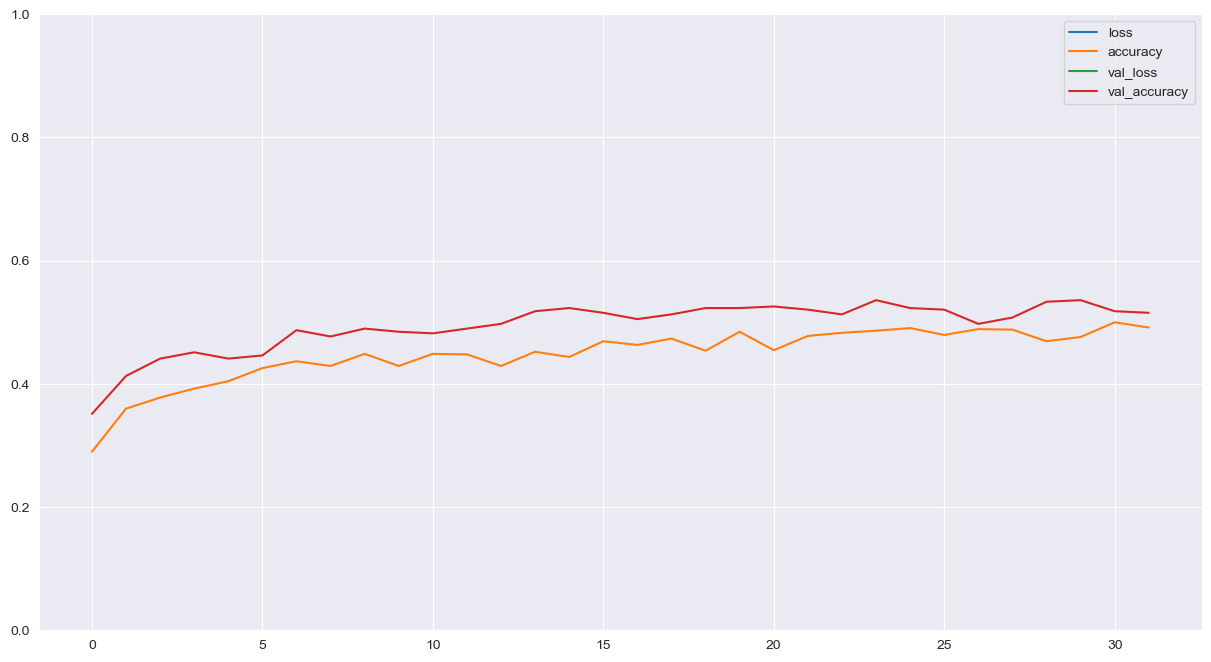

In [28]:
pd.DataFrame(history.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [29]:
model.predict(X_test)

13/13 [==============================] - 0s 816us/step


array([[0.1462368 , 0.18403496, 0.04828521, 0.6214431 ],
       [0.26895943, 0.2841638 , 0.13139962, 0.31547713],
       [0.01997037, 0.36584467, 0.16271147, 0.45147344],
       ...,
       [0.0031582 , 0.3209409 , 0.17289259, 0.50300825],
       [0.31205514, 0.18889031, 0.21387771, 0.2851769 ],
       [0.00250419, 0.57152534, 0.02135197, 0.4046185 ]], dtype=float32)

In [30]:
y_test

array([3, 1, 1, 3, 2, 0, 3, 1, 3, 1, 0, 3, 2, 1, 1, 1, 2, 1, 0, 1, 3, 2,
       3, 1, 2, 2, 3, 1, 2, 3, 3, 1, 1, 1, 1, 1, 3, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 3, 3, 1, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 0,
       2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 2, 3, 1, 1, 3, 3, 2, 1, 3, 3, 3, 3,
       3, 0, 1, 3, 0, 3, 1, 3, 1, 3, 2, 1, 1, 0, 1, 3, 3, 1, 0, 0, 0, 3,
       1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 2, 3, 0, 1, 1, 1,
       1, 0, 3, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 3, 1, 0, 0, 1, 3, 3, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 3, 3, 3, 1, 3, 2, 1, 1, 1, 1,
       1, 3, 0, 0, 0, 3, 0, 2, 3, 3, 0, 3, 2, 3, 1, 1, 1, 0, 1, 3, 3, 0,
       1, 0, 1, 3, 3, 2, 1, 3, 3, 2, 1, 2, 3, 3, 1, 1, 3, 3, 1, 0, 3, 1,
       1, 1, 3, 0, 2, 3, 0, 3, 1, 0, 1, 3, 2, 3, 3, 3, 0, 3, 3, 1, 3, 2,
       1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 0, 0,
       1, 3, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 1, 3, 1, 3,
       3, 3, 3, 1, 0, 0, 1, 0, 3, 1, 1, 1, 1, 2, 0,

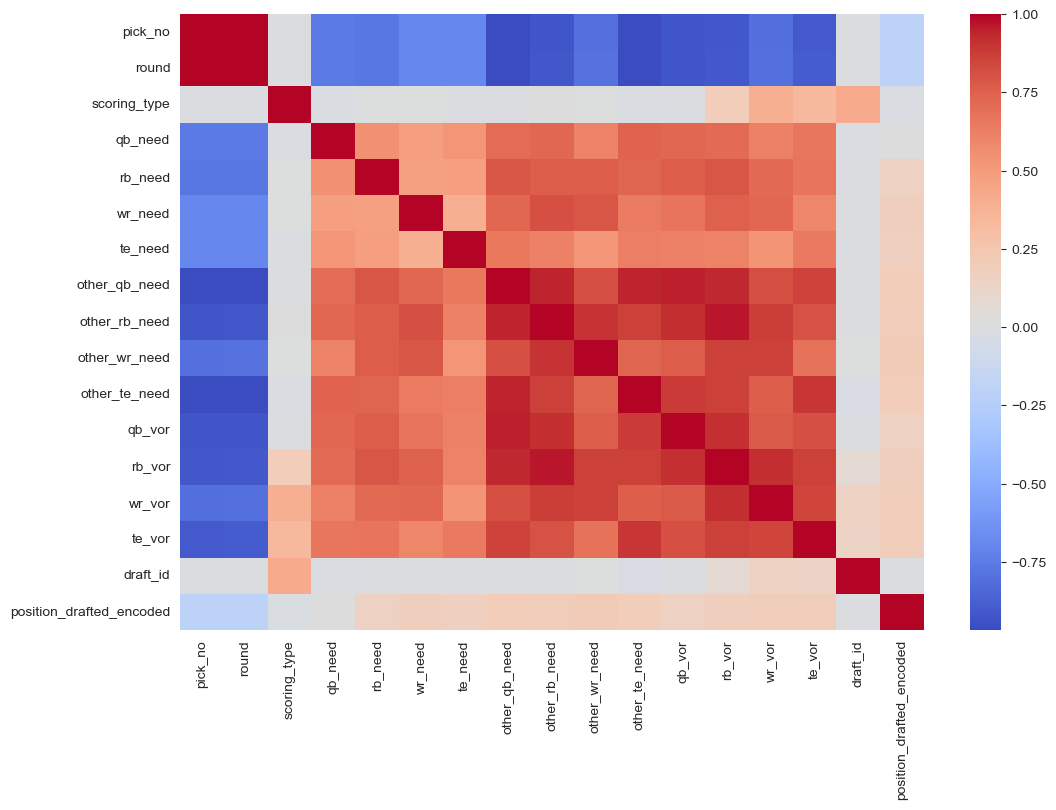